In [30]:
#imports
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN
from sklearn import metrics 
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.manifold import TSNE
from umap import UMAP
import scikitplot as skplot

# color maps
from matplotlib import cm

# for distance and h-clustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist, squareform


# sklearn does have some functionality too, but mostly a wrapper to scipy
from sklearn.metrics import pairwise_distances 
from sklearn.preprocessing import StandardScaler

pd.options.display.max_columns = None

In [12]:
df = pd.read_csv('melb_data.csv')

df.head(5)

df.shape

(13580, 21)

In [13]:
#data types of each feature 
df.dtypes

# checking for null values
df.isnull().sum()

# converting the date column to 'datetime'
# the dataset consists of housing sales between 2016-2017
df['Date'] = pd.to_datetime(df['Date'])

#creating columns for the date and month the apartment was sold 
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

import calendar
df['Month'] = df['Month'].apply(lambda x: calendar.month_abbr[x])

#real estate count per year and month
df.groupby(['Year', 'Month'])['Year'].count()

#dropping columns of no significance
df.drop(columns=['YearBuilt', 'Postcode', 'Address'], inplace=True)

#filling null values for council area with 'unavailable'
df['CouncilArea'] = df.CouncilArea.fillna('Unavailable')

#dropping observations with null values for car
df.dropna(subset=['Car'], inplace=True)

df.groupby(['BuildingArea', 'Suburb'])['Suburb'].count()

BuildingArea  Suburb       
0.0           Balwyn North     2
              Brighton East    1
              Bundoora         2
              Craigieburn      1
              Epping           1
                              ..
1561.0        Elsternwick      1
3112.0        Camberwell       1
3558.0        Fitzroy North    1
6791.0        Bulleen          1
44515.0       New Gisborne     1
Name: Suburb, Length: 5984, dtype: int64

<AxesSubplot:>

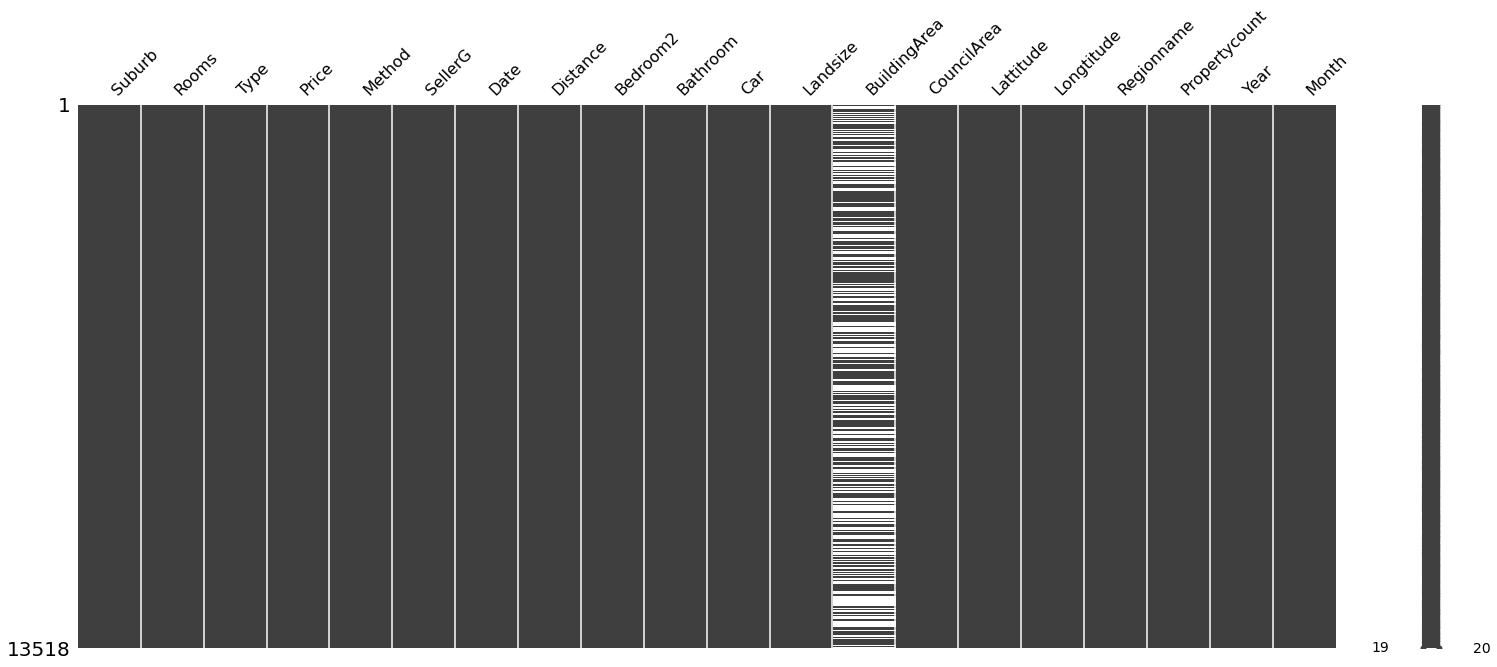

In [15]:
msno.matrix(df)

In [16]:
numeric = df.select_dtypes('number').copy()
del numeric['Year']
del numeric['BuildingArea']

In [17]:
numeric.head(3)

,Rooms,Price,Distance,Bedroom2,Bathroom,Car,Landsize,Lattitude,Longtitude,Propertycount
0,2,1480000.0,2.5,2.0,1.0,1.0,202.0,-37.7996,144.9984,4019.0
1,2,1035000.0,2.5,2.0,1.0,0.0,156.0,-37.8079,144.9934,4019.0
2,3,1465000.0,2.5,3.0,2.0,0.0,134.0,-37.8093,144.9944,4019.0


In [18]:
## Scaling
scaler = StandardScaler()
scaler.fit(numeric)
scaled = scaler.transform(numeric)
scaled = pd.DataFrame(scaled, columns = numeric.columns)
scaled.head(3)

,Rooms,Price,Distance,Bedroom2,Bathroom,Car,Landsize,Lattitude,Longtitude,Propertycount
0,-0.982624,0.633294,-1.306489,-0.948018,-0.773325,-0.633780,-0.089071,0.120843,0.029746,-0.784357
1,-0.982624,-0.062198,-1.306489,-0.948018,-0.773325,-1.672636,-0.100577,0.016261,-0.018332,-0.784357
2,0.062961,0.609850,-1.306489,0.086476,0.671169,-1.672636,-0.106079,-0.001380,-0.008716,-0.784357


In [29]:
## PCA
pca_m = PCA(.9)
pca_m.fit(scaled)
pcs_m = pca_m.transform(scaled)

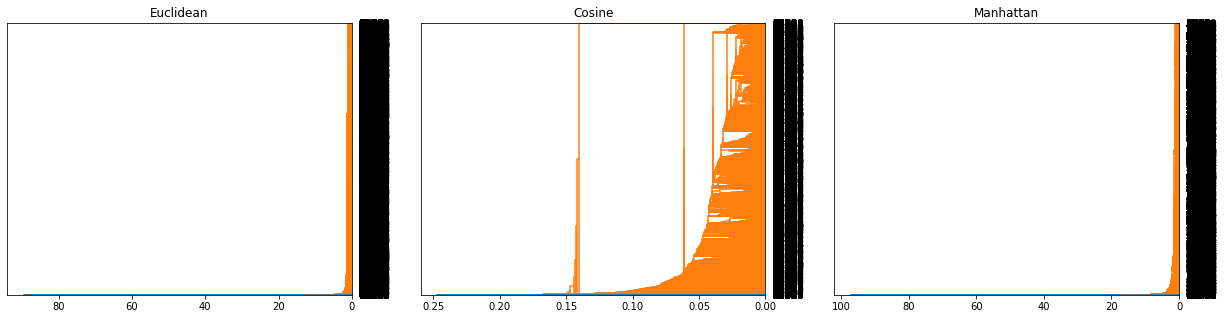

In [23]:
## Hierarchical Clustering

# Calculate distances
dist_euclidean = pdist(scaled.values)
dist_manhattan = pdist(scaled.values, metric = "cityblock") 
dist_cosine = pdist(scaled.values, metric = "cosine")

# Linkages
hclust_e = linkage(dist_euclidean)
hclust_c = linkage(dist_cosine)
hclust_m = linkage(dist_manhattan)

# Plot distance metrics
linkages = [hclust_e, hclust_c, hclust_m]
metrics = ['Euclidean', 'Cosine', 'Manhattan']
plt.figure(figsize = (21,5))
for i, m in enumerate(linkages):
    plt.subplot(1,3, i+1)
    plt.title(metrics[i])
    dendrogram(m,
              labels=scaled.index,
              leaf_font_size=10,
              orientation='left')

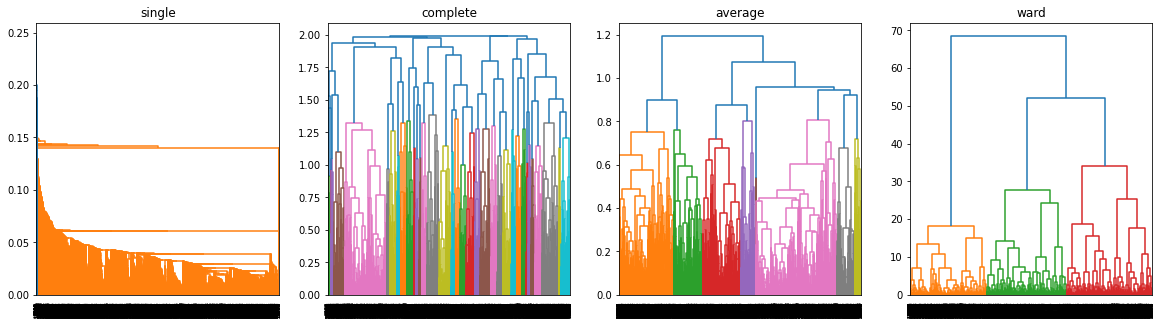

In [24]:
# Plot linkage methods for cosine
methods = ['single', 'complete', 'average', 'ward']
plt.figure(figsize = (20,5))
for i, m in enumerate(methods):
    plt.subplot(1, 4, i+1)
    plt.title(m)
    dendrogram(linkage(dist_cosine, method=m),
              leaf_rotation=90)

/Users/jeffrey/opt/miniconda3/envs/BA765/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


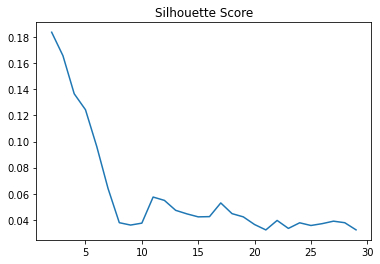

In [26]:
# Plotting silhouette scores
ks = range(2, 30)

silhouette = []

for k in ks:
    labs = fcluster(linkage(dist_cosine, method="complete"), k, criterion='maxclust')
    silhouette.append(silhouette_score(scaled, labs))

plt.title("Silhouette Score")
sns.lineplot(ks, silhouette)
plt.show()

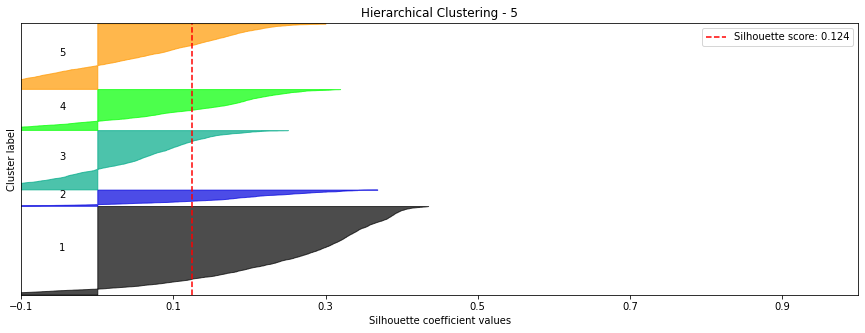

In [22]:
# Clustering 5 labels
labs = fcluster(linkage(dist_cosine, method="complete"), 5, criterion='maxclust')
df['cosine_complete_5'] = labs


skplot.metrics.plot_silhouette(scaled, labs, title="Hierarchical Clustering - 5", figsize=(15,5))
plt.show()

/Users/jeffrey/opt/miniconda3/envs/BA765/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/jeffrey/opt/miniconda3/envs/BA765/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


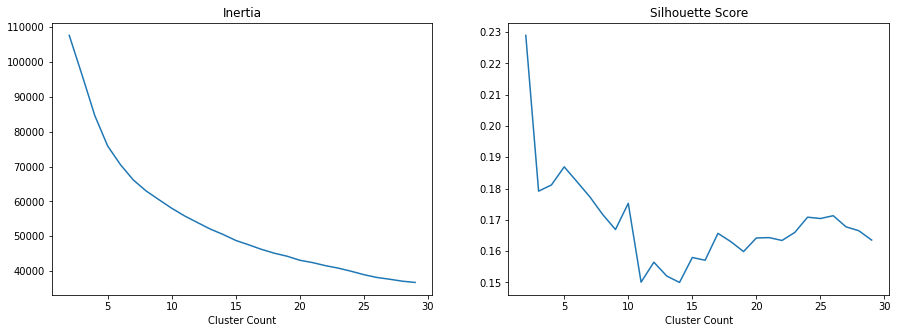

In [30]:
## KMeans

# Plotting inertia and silhouette
ks = range(2, 30)

inertia = []
silhouette = []

for k in ks:
    km = KMeans(k)
    km.fit(scaled)
    labels = km.predict(scaled)
    inertia.append(km.inertia_)
    silhouette.append(silhouette_score(scaled, labels))

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.title("Inertia")
sns.lineplot(ks, inertia)
plt.xlabel('Cluster Count')
plt.subplot(1, 2, 2)
plt.title("Silhouette Score")
sns.lineplot(ks, silhouette)
plt.xlabel('Cluster Count')
plt.show()

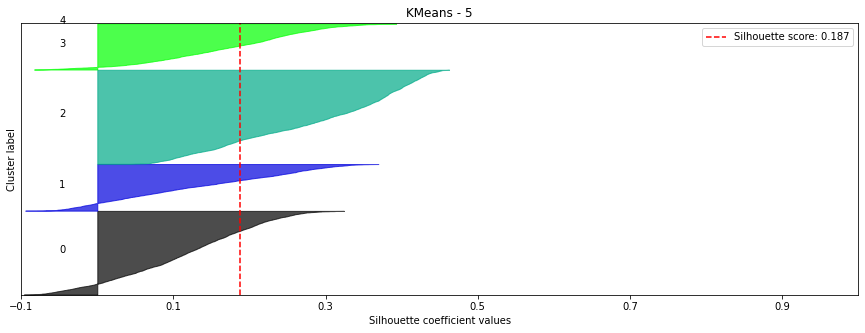

In [23]:
# Clustering for 6 labels
k5 = KMeans(5)
k5_labs = k5.fit_predict(scaled)

# Plotting Individual Cluster Silhouette Scores
skplot.metrics.plot_silhouette(scaled, k5_labs, title="KMeans - 5", figsize=(15,5))
plt.show()

In [24]:
df['kmeans_5'] = k5_labs

In [25]:
df.groupby("kmeans_5").mean()

,Rooms,Price,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,Lattitude,Longtitude,Propertycount,Year,cosine_complete_5
kmeans_5,,,,,,,,,,,,,
0,3.221691,8.609144e+05,11.321237,3.199952,1.483755,1.862876,561.322742,168.670663,-37.748674,144.921333,7158.132824,2016.564023,3.312470
1,4.103729,1.996376e+06,9.183583,4.074153,2.435919,2.189027,614.349764,234.451651,-37.825634,145.033117,7116.012002,2016.522503,4.748393
2,2.007655,7.852860e+05,6.614289,1.985329,1.119711,0.971508,391.632362,90.388419,-37.810609,144.984440,8131.051244,2016.440357,1.394642
3,3.152505,1.120638e+06,16.291242,3.130283,1.565142,1.869281,647.800871,154.605268,-37.899952,145.114068,6959.241830,2016.666667,3.471460
4,3.000000,2.700000e+06,2.100000,3.000000,3.000000,1.000000,433014.000000,NaN,-37.797510,144.983090,5825.000000,2017.000000,1.000000


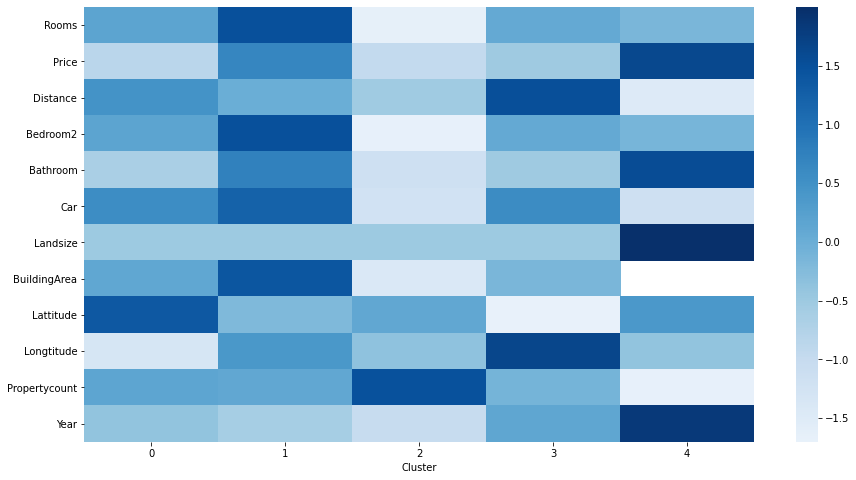

In [27]:
# Examining Cluster Means created with cosine metric and complete method
x = df.copy()
del x['cosine_complete_5']
cluster_profile = x.groupby('kmeans_5').mean()
cluster_profile.T

# Creating heatmap 
clust_scaler = StandardScaler()
cluster_scaled = clust_scaler.fit_transform(cluster_profile)

cluster_scaled = pd.DataFrame(cluster_scaled, 
                              index=cluster_profile.index, 
                              columns=cluster_profile.columns)

plt.figure(figsize=(15,8))
ax = sns.heatmap(cluster_scaled.T, cmap="Blues", center=0)
plt.xlabel('Cluster')
plt.show()

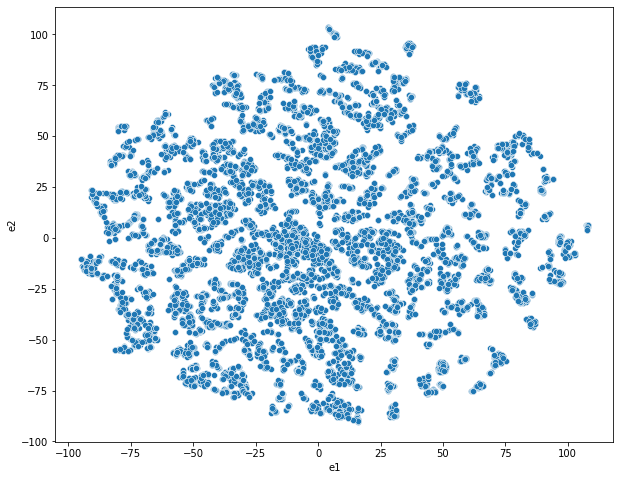

In [41]:
## TSNE

tsne = TSNE()
tsne.fit(pcs_m)

te = tsne.embedding_

tdata = pd.DataFrame(te, columns=["e1", "e2"])

PAL = sns.color_palette("bright", 10) 
plt.figure(figsize=(10, 8))
sns.scatterplot(x="e1", y="e2", data=tdata, legend="full", palette=PAL)
plt.show()

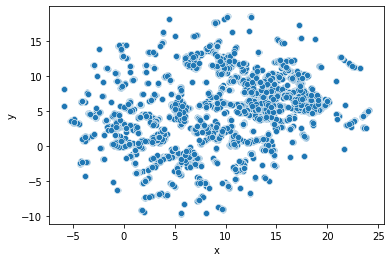

In [42]:
## UMAP

u = UMAP(random_state=820, n_neighbors=10)
u.fit(scaled)
ue = u.transform(scaled)

umap_df = pd.DataFrame(ue, columns=['x', 'y'])

sns.scatterplot(x="x", y="y", data=umap_df)
plt.figure(figsize=(10, 8))
plt.show()